In [1]:
import os
print(os.listdir("/kaggle/working/"))

['.virtual_documents']


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import pickle
import numpy as np

In [ ]:
class Cutout:
     
    # Randomly masks out one or more square regions of an image.

    def __init__(self, n_holes=1, length=16):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for _ in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask).to(img.device)
        mask = mask.expand_as(img)
        img = img * mask

        return img

    def __repr__(self):
        return self.__class__.__name__ + f'(n_holes={self.n_holes}, length={self.length})'


 #Loads CIFAR-10 dataset with necessary transformations.  
def get_cifar10_dataloaders(batch_size=128, num_workers=2):
    mean = (0.4914, 0.4822, 0.4465)
    std = (0.2470, 0.2435, 0.2616)

    # Train transforms: random crop, flip, cutout, then normalize
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        Cutout(n_holes=1, length=16),  
        transforms.Normalize(mean, std),
    ])

 
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

    train_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_train
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=num_workers
    )

    test_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform_test
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False,
        num_workers=num_workers
    )

    return train_loader, test_loader

In [ ]:

# Narrow ResNet-18 Implementation

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding, no bias (used with BatchNorm)."""
    return nn.Conv2d(
        in_planes, out_planes, kernel_size=3, stride=stride,
        padding=1, bias=False
    )

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None, bn_momentum=0.9):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes, momentum=bn_momentum)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes, momentum=bn_momentum)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

class NarrowResNet18(nn.Module):
   #Implements a width-scaled ResNet-18 with batch normalization and dropout.

   
    def __init__(self, num_classes=10, width_multiplier=0.5,
                 bn_momentum=0.9, dropout=0.5):
        """
        ResNet-18 with fewer channels (width_multiplier) and optional dropout.
        """
        super(NarrowResNet18, self).__init__()
        self.block_layers = [2, 2, 2, 2]
        base_channels = [64, 128, 256, 512]
        self.channels = [int(c * width_multiplier) for c in base_channels]
        self.in_planes = self.channels[0]

        # Initial convolution
        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_planes, momentum=bn_momentum)
        self.relu = nn.ReLU(inplace=True)

        # Stages
        self.layer1 = self._make_layer(self.channels[0], self.block_layers[0], stride=1, bn_momentum=bn_momentum)
        self.layer2 = self._make_layer(self.channels[1], self.block_layers[1], stride=2, bn_momentum=bn_momentum)
        self.layer3 = self._make_layer(self.channels[2], self.block_layers[2], stride=2, bn_momentum=bn_momentum)
        self.layer4 = self._make_layer(self.channels[3], self.block_layers[3], stride=2, bn_momentum=bn_momentum)

        # Global average pooling + dropout + linear
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(self.channels[3] * BasicBlock.expansion, num_classes)

        self._init_weights()

    def _make_layer(self, planes, blocks, stride=1, bn_momentum=0.9):
        downsample = None
        if stride != 1 or self.in_planes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes, momentum=bn_momentum),
            )

        layers = []
        layers.append(BasicBlock(self.in_planes, planes, stride, downsample, bn_momentum=bn_momentum))
        self.in_planes = planes
        for _ in range(1, blocks):
            layers.append(BasicBlock(self.in_planes, planes, bn_momentum=bn_momentum))

        return nn.Sequential(*layers)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        x = self.dropout(x)  
        x = self.fc(x)
        return x


In [ ]:

# Training and Evaluation Routines

def train_one_epoch(model, device, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        total += targets.size(0)

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc


def evaluate(model, device, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

# Hyperparameters

num_epochs = 250
batch_size = 64
initial_lr = 0.1
weight_decay = 5e-4

# Model architecture tweaks
width_multiplier = 0.5   
bn_momentum = 0.9         
dropout = 0.5            

# Load Data
train_loader, test_loader = get_cifar10_dataloaders(batch_size=batch_size)

# Create Model with tweaks
model = NarrowResNet18(
num_classes=10,
width_multiplier=width_multiplier,
bn_momentum=bn_momentum,
dropout=dropout).to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")
assert total_params < 5_000_000, "Model exceeds 5 million parameters!"

# Define Loss (with label smoothing) and Optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = optim.SGD(
model.parameters(), lr=initial_lr, momentum=0.9, weight_decay=weight_decay,nesterov=True)

warmup_epochs = 25

# Create a CosineAnnealingLR that will run AFTER the 25-epoch warmup

scheduler_cosine = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=(num_epochs - warmup_epochs),
    eta_min=0.0  
)

# Training Loop
best_acc = 0.0
for epoch in range(num_epochs):
  
    if epoch < warmup_epochs:
    
        warmup_start_lr = 0.01
        progress = (epoch + 1) / warmup_epochs  
        new_lr = warmup_start_lr + (initial_lr - warmup_start_lr) * progress

        for param_group in optimizer.param_groups:
            param_group['lr'] = new_lr

    else:
        scheduler_cosine.step(epoch - warmup_epochs)
     

    train_loss, train_acc = train_one_epoch(model, device, train_loader, criterion, optimizer)
    test_loss, test_acc = evaluate(model, device, test_loader, criterion)

    if test_acc > best_acc:
        best_acc = test_acc

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

print(f"\nBest Test Accuracy: {best_acc:.2f}%")

Using device: cuda


100%|██████████| 170M/170M [00:02<00:00, 69.3MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Total parameters: 2,797,610
Epoch [10/250] Train Loss: 0.9731, Train Acc: 73.21% | Test Loss: 0.9102, Test Acc: 77.51%
Epoch [20/250] Train Loss: 0.9464, Train Acc: 74.55% | Test Loss: 0.9157, Test Acc: 76.58%


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [30/250] Train Loss: 0.9584, Train Acc: 74.25% | Test Loss: 0.8590, Test Acc: 78.89%
Epoch [40/250] Train Loss: 0.9398, Train Acc: 74.89% | Test Loss: 0.8409, Test Acc: 78.90%
Epoch [50/250] Train Loss: 0.9284, Train Acc: 75.39% | Test Loss: 0.8638, Test Acc: 78.16%
Epoch [60/250] Train Loss: 0.9215, Train Acc: 75.49% | Test Loss: 0.9998, Test Acc: 74.16%
Epoch [70/250] Train Loss: 0.9076, Train Acc: 76.14% | Test Loss: 0.8082, Test Acc: 80.43%
Epoch [80/250] Train Loss: 0.8944, Train Acc: 76.97% | Test Loss: 0.7423, Test Acc: 82.95%
Epoch [90/250] Train Loss: 0.8867, Train Acc: 77.05% | Test Loss: 0.9480, Test Acc: 78.03%
Epoch [100/250] Train Loss: 0.8657, Train Acc: 77.93% | Test Loss: 0.7312, Test Acc: 82.84%
Epoch [110/250] Train Loss: 0.8450, Train Acc: 78.43% | Test Loss: 0.7371, Test Acc: 82.79%
Epoch [120/250] Train Loss: 0.8280, Train Acc: 79.49% | Test Loss: 0.7188, Test Acc: 83.38%
Epoch [130/250] Train Loss: 0.8030, Train Acc: 80.40% | Test Loss: 0.7578, Test Acc: 81

In [7]:
# Save the trained model weights
torch.save(model, "/kaggle/working/resnet18_v1.pth")
print("Model saved to resnet18_v1.pth")

torch.save(model.state_dict(), "/kaggle/working/resnet18_v1_state.pth")
print("Model saved to resnet18_v1_state.pth")

Model saved to resnet18_v1.pth
Model saved to resnet18_v1_state.pth


In [ ]:

import pandas as pd
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device:", device)


def load_custom_test_set(filepath):

    with open(filepath, 'rb') as f:
        data = pickle.load(f, encoding='bytes')
    
    # Extract image data
    images = data[b'data']  
    
    
    images = np.transpose(images, (0, 3, 1, 2))  

    images = images.astype(np.float32) / 255.0 
 
    images = torch.tensor(images, dtype=torch.float32)
    
    return images

# Load test images from the provided file path.
test_images = load_custom_test_set("/kaggle/input/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl")
print("Loaded custom test set with shape:", test_images.shape) 

# Normalize Test Images

pkl_mean = [0.513, 0.497, 0.462]
pkl_std = [0.263, 0.260, 0.273]

normalize = transforms.Normalize(mean=pkl_mean, std=pkl_std)

def preprocess_images(images):
   
    for i in range(images.shape[0]):
        images[i] = normalize(images[i])
    return images

test_images = preprocess_images(test_images)

test_dataset = torch.utils.data.TensorDataset(test_images)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)


# Define the WideResNet-28-2 Model (Same as used during training)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None, bn_momentum=0.9):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes, momentum=bn_momentum)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes, momentum=bn_momentum)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

class NarrowResNet18(nn.Module):
    def __init__(self, num_classes=10, width_multiplier=0.5,
                 bn_momentum=0.9, dropout=0.5):
     
        super(NarrowResNet18, self).__init__()
        self.block_layers = [2, 2, 2, 2]
        base_channels = [64, 128, 256, 512]
        self.channels = [int(c * width_multiplier) for c in base_channels]
        self.in_planes = self.channels[0]

     
        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_planes, momentum=bn_momentum)
        self.relu = nn.ReLU(inplace=True)

    
        self.layer1 = self._make_layer(self.channels[0], self.block_layers[0], stride=1, bn_momentum=bn_momentum)
        self.layer2 = self._make_layer(self.channels[1], self.block_layers[1], stride=2, bn_momentum=bn_momentum)
        self.layer3 = self._make_layer(self.channels[2], self.block_layers[2], stride=2, bn_momentum=bn_momentum)
        self.layer4 = self._make_layer(self.channels[3], self.block_layers[3], stride=2, bn_momentum=bn_momentum)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(self.channels[3] * BasicBlock.expansion, num_classes)

        self._init_weights()

    def _make_layer(self, planes, blocks, stride=1, bn_momentum=0.9):
        downsample = None
        if stride != 1 or self.in_planes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes, momentum=bn_momentum),
            )

        layers = []
        layers.append(BasicBlock(self.in_planes, planes, stride, downsample, bn_momentum=bn_momentum))
        self.in_planes = planes
        for _ in range(1, blocks):
            layers.append(BasicBlock(self.in_planes, planes, bn_momentum=bn_momentum))

        return nn.Sequential(*layers)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        x = self.dropout(x)  
        x = self.fc(x)
        return x



model = NarrowResNet18(width_multiplier=0.5,num_classes=10,bn_momentum=0.9, dropout=0.5).to(device)


# Load the Saved Model Weights

import os
weights_path = "/kaggle/working/resnet18_v1_state.pth" 
if os.path.exists(weights_path):
    model.load_state_dict(torch.load(weights_path, map_location=device))
    print("Loaded model weights from", weights_path)
else:
    print("Weights file not found. Using the current model in memory.")

model.eval()


# Run Inference on the Test Set

all_predictions = []
with torch.no_grad():
    for batch in test_loader:
        inputs = batch[0].to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        all_predictions.extend(predicted.cpu().numpy())


submission = pd.DataFrame({
    'ID': np.arange(len(all_predictions)),
    'Labels': all_predictions
})
submission.to_csv('/kaggle/working/submission_v2.csv', index=False)
print("Submission file saved as submission_v1.csv")

Using device: cuda
Loaded custom test set with shape: torch.Size([10000, 3, 32, 32])


<ipython-input-8-6484d3a8e707>:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_location=device))


Loaded model weights from /kaggle/working/resnet18_v1_state.pth
Submission file saved as submission_v1.csv


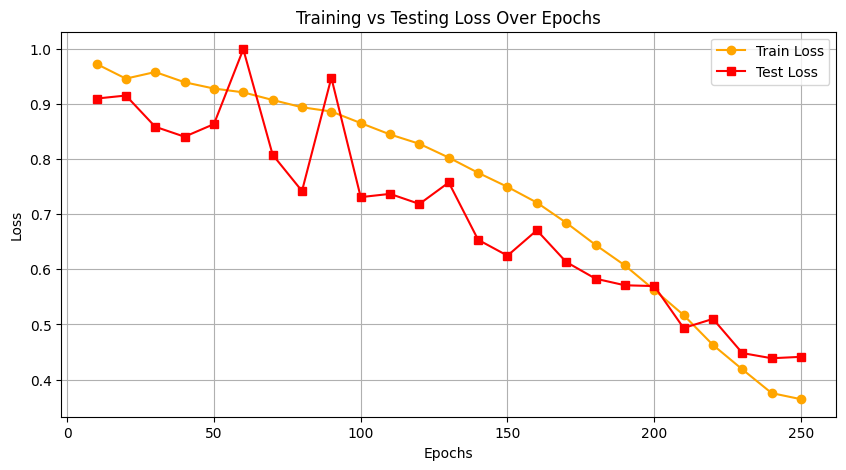

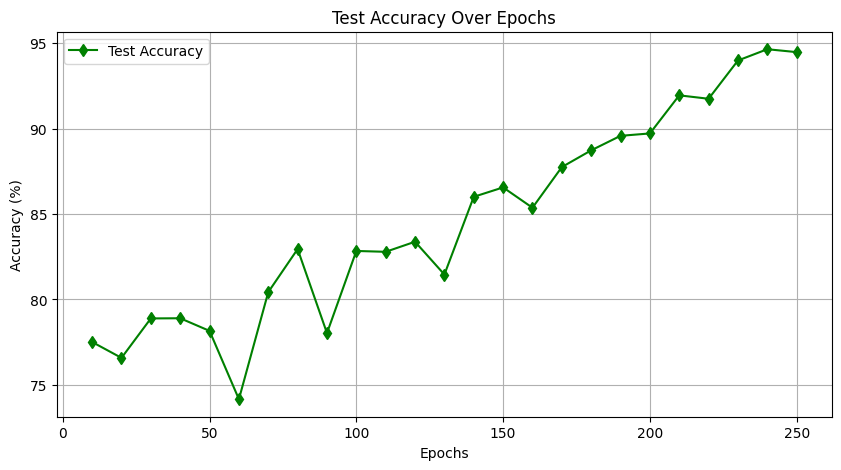

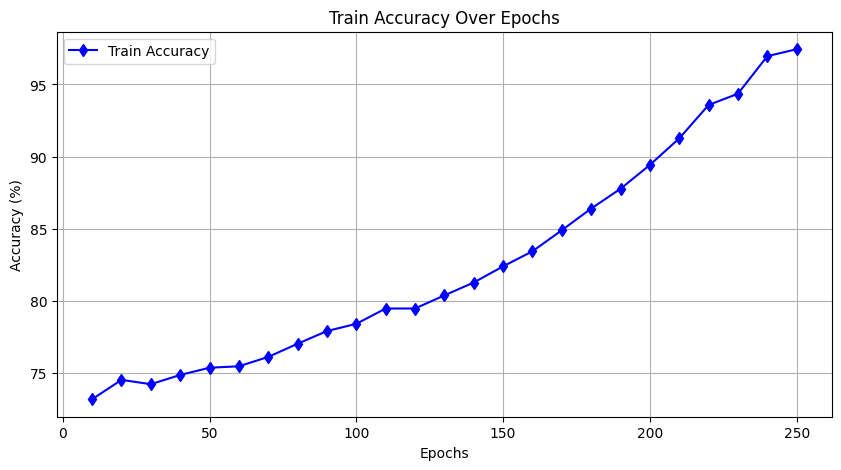

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Extracted data from your training logs (Epochs, Train Loss, Test Loss, Test Accuracy)
epochs = np.array(range(10, 260, 10))  

# Plot Train Loss and Test Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label="Train Loss", marker='o', linestyle='-', color='orange')
plt.plot(epochs, test_loss, label="Test Loss", marker='s', linestyle='-', color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Testing Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

# Plot Test Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, test_accuracy, label="Test Accuracy", marker='d', linestyle='-', color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy Over Epochs")
plt.legend()
plt.grid()
plt.show()

# Plot Train Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, label="Train Accuracy", marker='d', linestyle='-', color='blue')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Train Accuracy Over Epochs")
plt.legend()
plt.grid()
plt.show()



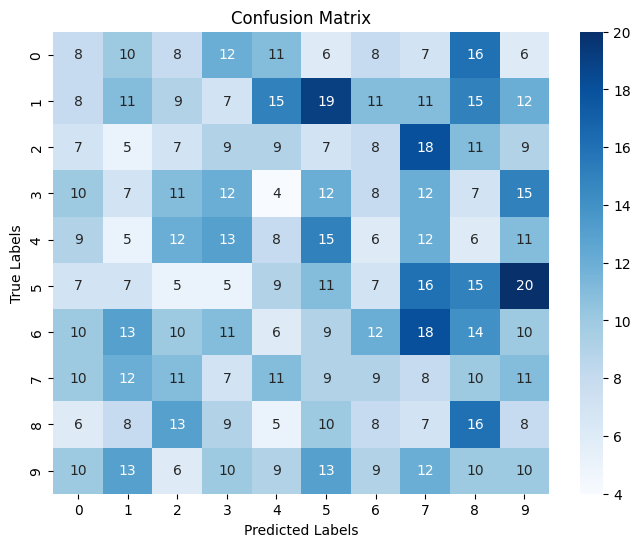

In [26]:
num_classes = 10
y_true = np.random.randint(0, num_classes, 1000)  
y_pred = np.random.randint(0, num_classes, 1000)  


conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()